---
title: "Non-linear Modeling"
author: "phonchi"
date: "11/07/2022"
format: 
  html:
    toc: true
    code-line-numbers: true
    code-tools: true
---

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_7_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_7_Lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br/>

## Setup

In this lab, we re-analyze the `Wage` data considered in the examples throughout this chapter, in order to illustrate the fact that
many of the complex non-linear fitting procedures discussed  can be easily implemented in `Python`.

In [ ]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.generalized_additive_model import LogitGam
from patsy import dmatrix
import patsy as pt
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
from numpy.linalg import inv
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [ ]:
class SmoothingSpline1D(BaseEstimator, TransformerMixin):
# https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Bone%20Mineral%20Density.ipynb  
    """One dimensional smoothing spline.
    Parameters
    ----------
    dof :
        The target effective degrees of of freedom of a smoothing spline.
    Attributes
    ----------
    knots_:
        Unique values of X training data.
    smooth_:
        The smoothing parameter that results in the target degrees of freedom.
    coef_:
        The vector of fitted coefficients for linear regression."""
    def __init__(self, dof: float):
        self.dof = dof

    def fit(self, X: np.ndarray, y: np.array) -> 'SmoothingSpline1D':
        """Fit SmoothingSpline1D model according to the given training data
           and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        y = np.atleast_2d(y).T
        self.knots_ = np.unique(X)
        N = self.__expand_natural_cubic(X, self.knots_)
        O = self.__calc_integral_matrix(self.knots_)
        self.smooth_ = optimize.newton(
            lambda s: self.__calc_dof(N, O, s) - self.dof,
            0.5, maxiter=400)
        self.coef_ = inv(N.T @ N + self.smooth_ * O) @ N.T @ y
        self.Sl_ = self.__calc_Sl(N, O, self.smooth_)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Natural cubic spline basis expansion.
        Parameters
        ----------
        X :
            Input data.
        Returns
        -------
        X_new :
            Transformed data.
        """
        return self.__expand_natural_cubic(X, self.knots_)

    def predict(self, X: np.ndarray) -> np.array:
        return self.transform(X) @ self.coef_

    @staticmethod
    def __calc_Sl(N, O, smoothing):
        return N @ inv(N.T @ N + smoothing * O) @ N.T

    @staticmethod
    def __calc_dof(N, O, smoothing):
        if smoothing < 0:
            smoothing = 0
        return np.trace(SmoothingSpline1D.__calc_Sl(N, O, smoothing))

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [np.ones(shape=(X.size, 1)), X]
        dk_last = SmoothingSpline1D.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = SmoothingSpline1D.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __calc_integral_matrix(knots: np.array) -> np.ndarray:
        O = np.zeros(shape=(knots.size, knots.size))
        for i in range(2, knots.size):
            for j in range(i, knots.size):
                O[i, j] = O[j, i] = SmoothingSpline1D.__calc_integral(
                    knots[i-2], knots[j-2], knots[-2], knots[-1])
        return O

    @staticmethod
    def __calc_integral(i, j, p, l):
        return (-18*i*j*j + 12*i*j*l + 24*i*j*p - 12*i*l*p - 6*i*p*p +
                6*j*j*j - 12*j*l*p - 6*j*p*p + 12*l*p*p) / \
               (i*j - i*l - j*l + l*l)

## Polynomial Regression
We now examine how Figure 7.1 was produced. We first fit the model using the following command:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
Wage = pd.read_csv('/content/drive/MyDrive/Lab/Data/Wage.csv')
print(Wage.shape)
Wage.head()

(3000, 11)


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
#Wage = Wage.drop(Wage.columns[0], axis=1) # the first col dones't seem to be that relevant

Wage['education'] = Wage['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })

Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
poly = PolynomialFeatures(4)
X = poly.fit_transform(Wage['age'].to_frame())
y = Wage['wage']
# X.shape

model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.77e-57
Time:                        07:35:04   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

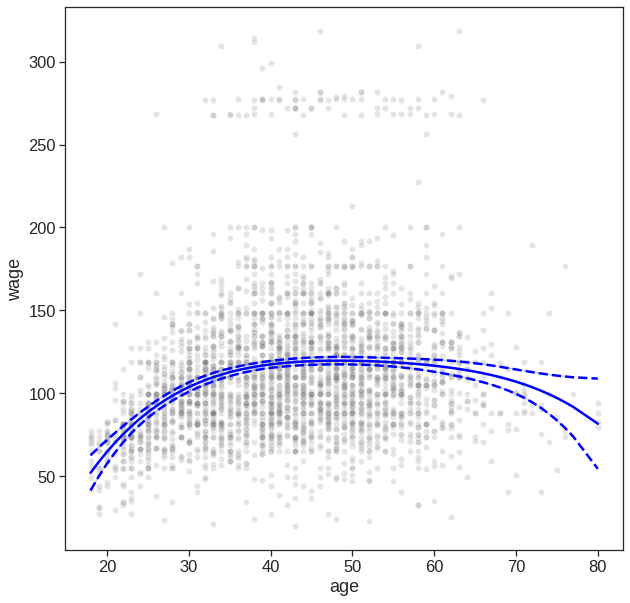

In [ ]:
# STATS
# ----------------------------------
# Reference: https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression

y_hat = model.predict(X)

# Covariance of coefficient estimates
mse = np.sum(np.square(y_hat - y)) / y.size
cov = mse * np.linalg.inv(X.T @ X)
# ...or alternatively this stat is provided by stats models:
#cov = model.cov_params()

# Calculate variance of f(x)
var_f = np.diagonal((X @ cov) @ X.T)
# Derive standard error of f(x) from variance
se       = np.sqrt(var_f)
conf_int = 2*se

# PLOT
# ----------------------------------
# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue');

# Plot confidence intervals
sns.lineplot(x=X[:, 1], y=y_hat+conf_int, color='blue');
sns.lineplot(x=X[:, 1], y=y_hat-conf_int, color='blue');
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

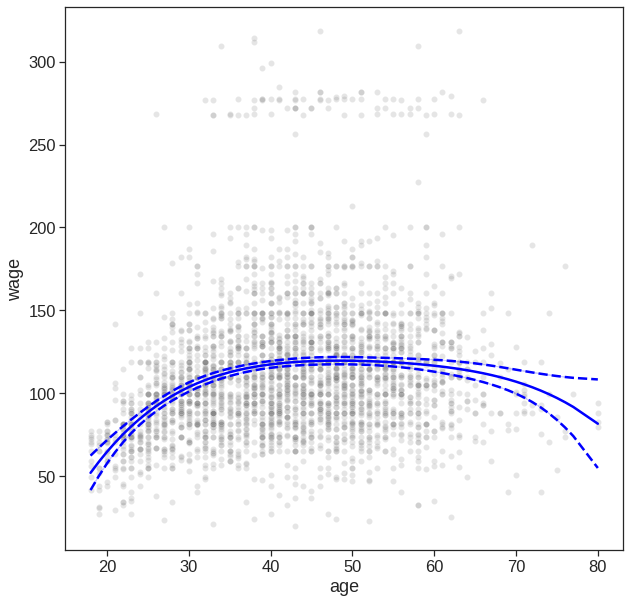

In [ ]:
y_hat = model.predict(X)
predictions = model.get_prediction()
df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue')

# Plot confidence intervals
#plt.fill_between(df_predictions.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='crimson') #prediction interval
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_lower, color='blue')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_upper, color='blue')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

If your goal is purely visualization, then you can simply use the seaborn package

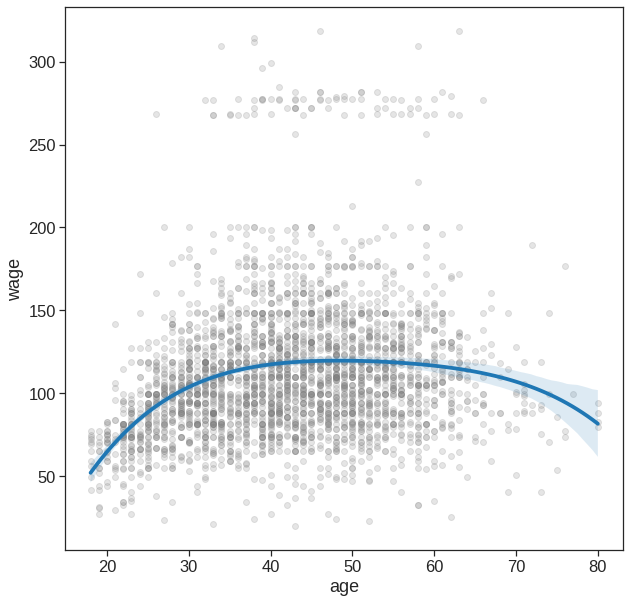

In [ ]:
# Easy to plot higher polynomial order regressions from seaborn
plt.figure(figsize=(10,10))
sns.regplot(x='age', y='wage', data=Wage, order=4, 
            scatter_kws={'alpha': 0.2, 'color': 'gray', 'facecolor': None});

You can also try to use bootstrap methods [https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot](https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot).

In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis
tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to
explain the relationship between `wage` and `age`. We use the `anova()` function, which performs an analysis of
  variance (ANOVA, using an F-test) in order to test the null hypothesis that a model $\mathcal{M}_1$ is sufficient to explain the
data against the alternative hypothesis that a more complex model $\mathcal{M}_2$ is required. In order to use the `anova()`
function, $\mathcal{M}_1$ and $\mathcal{M}_2$ must be *nested* models: the predictors in $\mathcal{M}_1$ must be a subset of the
predictors in $\mathcal{M}_2$. In this case, we fit five different models and sequentially compare the simpler model to the more complex
model.

Null hypothesis is that a model $\mathcal{M}_1$ is sufficient to explain the data, and alternative hypothese is that a more complex model is needed. 

[https://www.statsmodels.org/stable/anova.html](https://www.statsmodels.org/stable/anova.html).

In [ ]:
poly = PolynomialFeatures(5)
X = poly.fit_transform(Wage['age'].to_frame()) # or reshape(-1, 1)
y = Wage['wage']
X_df = pd.DataFrame(X)
X_df.columns = ['Constant']+['X_' + str(i) for i in range(1,6)]
X_df.head()

,Constant,X_1,X_2,X_3,X_4,X_5
0,1.0,18.0,324.0,5832.0,104976.0,1889568.0
1,1.0,24.0,576.0,13824.0,331776.0,7962624.0
2,1.0,45.0,2025.0,91125.0,4100625.0,184528125.0
3,1.0,43.0,1849.0,79507.0,3418801.0,147008443.0
4,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0


In [ ]:
fit_1 = sm.OLS(y,X_df.iloc[:,:2]).fit() #degree 1
fit_2 = sm.OLS(y,X_df.iloc[:,:3]).fit() #degree 2
fit_3 = sm.OLS(y,X_df.iloc[:,:4]).fit() #degree 3
fit_4 = sm.OLS(y,X_df.iloc[:,:5]).fit() #degree 4
fit_5 = sm.OLS(y,X_df.iloc[:,:6]).fit() #degree 5

table = sm.stats.anova_lm(fit_1,fit_2,fit_3,fit_4,fit_5)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


We can see from the table that p value for the second row is very small, of the order 10^-32. Through this we conclue that linear model is not sufficient to explain the data. 
Remember this was the alternative hypotheses. Since p value is very significant, we reject null hypothese, according to which linear model is enough to explain the data. 
the next couple of p values are small, not that small, but enough to reject the null hypotheses. 
But, if we see the p value of last row, which is comparing model with degree 4 and degre 5, we can see that the p value if approx 0.37. and hence its not that small. Through this we can conclude that model with degree 4 is enough to explain the data and we don't need a higher degree than that. 
Hence we conlude that model with degree 3 or 4 are reasonable to fit the data, but lower degree model and higher degre models
are not justified.

In [ ]:
# lets look at the model with degree 5
print(fit_5.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           1.67e-56
Time:                        07:35:34   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -49.7046    161.435     -0.308      0.7

We can see that the p value for X_5 is equal for the p value that we got in Annova, also the square of t value for X_5 give the value of F statistic that was there in ANNOVA. but thse are not true for X_1,X_2, and other predictors. Althoug if we look for p values for X_2, in fit_2, we will get the results as expected. Same is true for X_1 in fit 1, X_3 in fit_3, etc. (**We don't have orthogonal polynomial like R here!**)

Annova can also be used when we have other terms in the model

In [ ]:
# Derive 5 degree polynomial features of age
degree = 3
f = 'education +' + ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, Wage)
y = np.asarray(Wage['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:3]).fit()
model_2 = sm.OLS(y, X[:, 0:4]).fit()
model_3 = sm.OLS(y, X[:, 0:5]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model_1, model_2, model_3))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using  cross-validation, as discussed in Chapter 5.

Next we consider the task of predicting whether an individual earns more than $250,000$ per year. We proceed much as before, except that first we create the appropriate response vector, and then apply the `GLM()` function using `family = "Binomial"` in order to fit a polynomial logistic regression model.


In [ ]:
Wage['wage_binary'] = np.where(Wage['wage']>250,1,0)
print(Wage['wage_binary'].value_counts())
y = Wage['wage_binary']
poly = PolynomialFeatures(4)
X = poly.fit_transform(Wage['age'].to_frame())
X_df = pd.DataFrame(X)
X_df.columns = ['Constant']+['X_' + str(i) for i in range(1,5)]
X_df.head()

0    2921
1      79
Name: wage_binary, dtype: int64


,Constant,X_1,X_2,X_3,X_4
0,1.0,18.0,324.0,5832.0,104976.0
1,1.0,24.0,576.0,13824.0,331776.0
2,1.0,45.0,2025.0,91125.0,4100625.0
3,1.0,43.0,1849.0,79507.0,3418801.0
4,1.0,50.0,2500.0,125000.0,6250000.0


In [ ]:
## Fit logistic model
clf = sm.GLM(y, X_df, family=sm.families.Binomial(sm.families.links.logit()))
model = clf.fit()

#model = sm.Logit(y,X_df).fit()

Text(0, 0.5, 'Prob wage > 250k, given age')

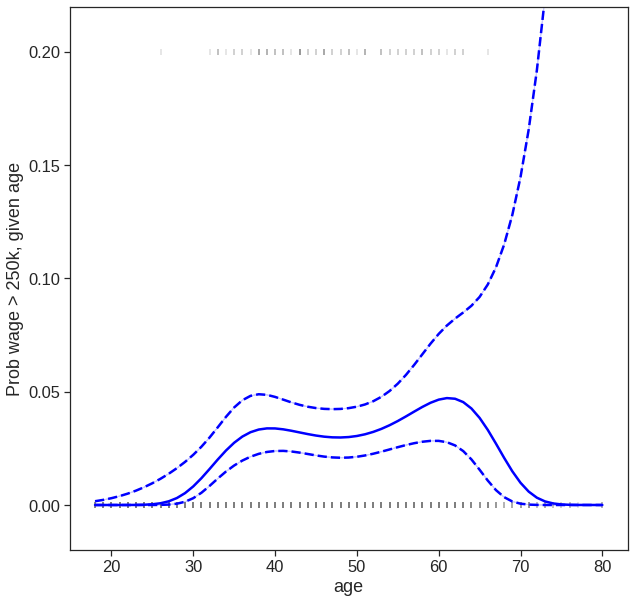

In [ ]:
y_hat = model.predict(X)

predictions = model.get_prediction()
df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y=Wage['wage_binary']/5,
                color='tab:gray',
                alpha=0.8,
                ax=ax,
                data=Wage, marker = '|')

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue')

# Plot confidence intervals
#plt.fill_between(df_predictions.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='crimson')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_lower, color='blue')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_upper, color='blue')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.set_ylim(-0.02,0.22)
ax.set_ylabel('Prob wage > 250k, given age')

## Step Functions

We have drawn  the `age` values corresponding to the observations with `wage` values above $250$ as gray marks on the top of the plot, and those with `wage` values below $250$ are shown as gray marks on the bottom of the plot. 

In order to fit a step function, as discussed in Section 7.2, we use the following function.

In [ ]:
#X_cut = pd.cut(Wage['age'],[0,25,40,65,90])
#X_cut
X_cut = pd.cut(Wage['age'],4)
X_cut

0       (17.938, 33.5]
1       (17.938, 33.5]
2         (33.5, 49.0]
3         (33.5, 49.0]
4         (49.0, 64.5]
             ...      
2995      (33.5, 49.0]
2996    (17.938, 33.5]
2997    (17.938, 33.5]
2998    (17.938, 33.5]
2999      (49.0, 64.5]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.938, 33.5] < (33.5, 49.0] < (49.0, 64.5] <
                                           (64.5, 80.0]]

In [ ]:
X_cut = pd.get_dummies(X_cut)
X_cut.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1,0,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [ ]:
y = Wage['wage']
model = sm.OLS(y,X_cut).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           1.13e-41
Time:                        07:36:09   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
(17.938, 33.5]    94.1584      1.476     63.

Here `pd.cut()` automatically picked the cutpoints at $33.5$, $49$, and $64.5$ years of age. The function returns an ordered categorical variable ; the `get_dummies()` function then creates a set of dummy variables for use in the regression. The `age < 33.5` category is not left out, so the intercept coefficient of $94.1584$ can be interpreted as the average salary for those under $33.5$ years of age, and the other coefficients can be also interpreted as the average salary for those in the other age groups. (Different from R here)

We can produce predictions and plots just as we did in the case of the polynomial fit.

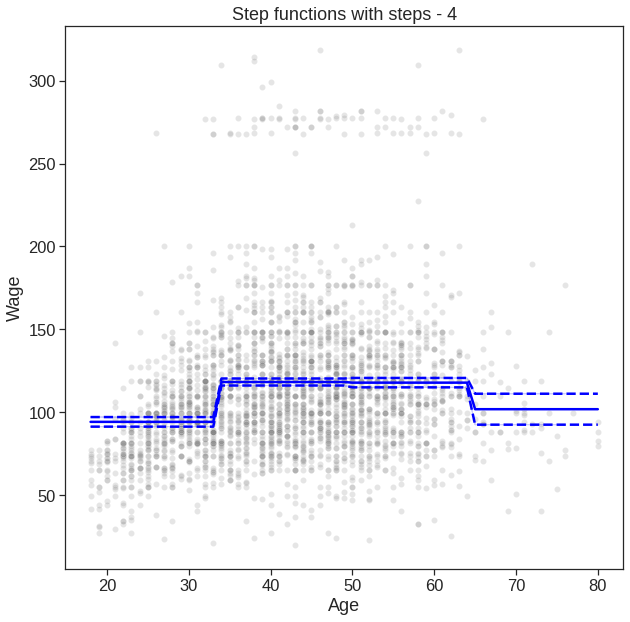

In [ ]:
pred_step = model.predict(X_cut)
predictions = model.get_prediction()
df_predictions = predictions.summary_frame()

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)
sns.lineplot(x=Wage['age'],y=pred_step, ax=ax, color='blue')

plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step functions with steps - 4')

# Plot confidence intervals
#plt.fill_between(df_predictions.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='crimson')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_lower, color='blue')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_upper, color='blue')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

## Splines

In Section 7.4, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions.
In order to fit regression splines in `Python`, we will do it by using `bs()` in dmatrix function from `patsy` library. So, briefly -- Data -> convert into matrix using dmatrix -> fit this with OLS, or GLM (generalised linear model). 

checkout this if you have some time - [https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/](https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/).

`pasty.dmatrix` - [https://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression](https://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression).

In [ ]:
# fit a spline with knots at 25, 40 and 60
transformed_x = dmatrix("bs(age , knots = (25,40,60), degree = 3, include_intercept = False)",data = {'age':Wage['age']}, return_type = 'dataframe')
transformed_x.shape

(3000, 7)

In [ ]:
transformed_x.head() #this looks complex (K+3 bais function)

,Intercept,"bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


In [ ]:
# fit a OLS model to the transformded data
model = sm.OLS(Wage['wage'], transformed_x).fit()

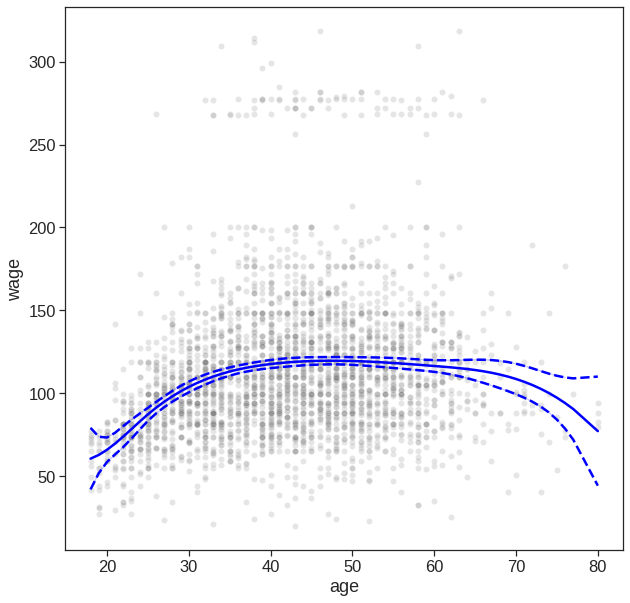

In [ ]:
y_hat = model.predict(transformed_x)

predictions = model.get_prediction()
df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue')

# Plot confidence intervals
#plt.fill_between(df_predictions.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='crimson')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_lower, color='blue')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_upper, color='blue')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
#ax.set_ylim(-0.02,0.22)
#ax.set_ylabel('Prob wage > 250k, given age')

Here we have prespecified knots at ages $25$, $40$, and $60$. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) 

### Natural spline

In order to instead fit a natural spline, we use the `cr()` function. Here we fit a natural spline with four degrees of freedom.

[https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.cr](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.cr).

In [ ]:
# fit a spline with knots at 25, 40 and 60
#transformed_x = dmatrix("cr(age , knots = (25,40,60))",data = {'age':Wage['age']}, return_type = 'dataframe')
#print(transformed_x.shape)
#transformed_x.head()
transformed_x2 = dmatrix("cr(age,df = 4)", {"age": Wage['age']}, return_type='dataframe')
transformed_x2.shape

(3000, 5)

In [ ]:
# fit a OLS model to the transformded data
model = sm.OLS(Wage['wage'], transformed_x2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     91.74
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           8.48e-57
Time:                        07:37:36   Log-Likelihood:                -15318.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2996   BIC:                         3.067e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           79.6421      1.773  

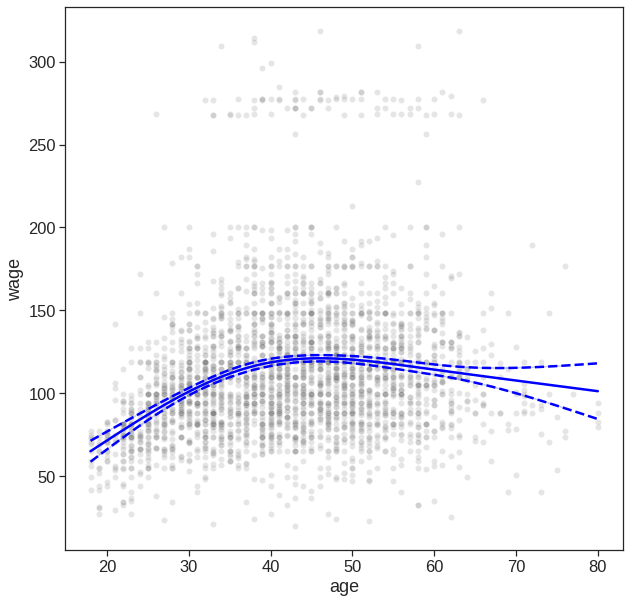

In [ ]:
y_hat = model.predict(transformed_x2)

predictions = model.get_prediction()
df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue')

# Plot confidence intervals
#plt.fill_between(df_predictions.index, df_predictions.obs_ci_lower, df_predictions.obs_ci_upper, alpha=.1, color='crimson')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_lower, color='blue')
sns.lineplot(x=X[:, 1], y=df_predictions.mean_ci_upper, color='blue')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
#ax.set_ylim(-0.02,0.22)
#ax.set_ylabel('Prob wage > 250k, given age')

### B-spline

Some of the advantages of splines over polynomials are:

- B-splines are very flexible and robust if you keep a fixed low degree, usually 3, and parsimoniously adapt the number of knots. Polynomials would need a higher degree, which leads to the next point.

- B-splines do not have oscillatory behaviour at the boundaries as have polynomials (the higher the degree, the worse). This is known as Runge’s phenomenon.

- B-splines provide good options for extrapolation beyond the boundaries, i.e. beyond the range of fitted values. Have a look at the option extrapolation.

- B-splines generate a feature matrix with a banded structure. For a single feature, every row contains only `degree + 1` non-zero elements, which occur consecutively and are even positive. This results in a matrix with good numerical properties, e.g. a low condition number, in sharp contrast to a matrix of polynomials, which goes under the name Vandermonde matrix. A low condition number is important for stable algorithms of linear models.

In [ ]:
# B-spline with 4 + 3 - 1 = 6 basis functions
spline = SplineTransformer(n_knots=4, degree=3)
X = spline.fit_transform(Wage['age'].to_frame())
y = Wage['wage']
# X.shape

model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.55
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.41e-56
Time:                        07:40:10   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -114.1421     60.244     -1.895      0.0

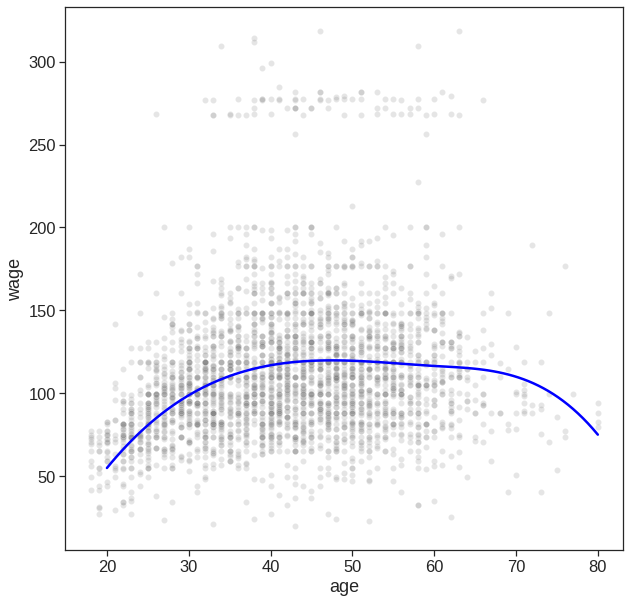

In [ ]:
test_ages = np.linspace(20,80,100)
X_test = spline.fit_transform(test_ages.reshape(-1,1))
y_hat = model.predict(X_test)

#y_hat = model.predict(X)
#predictions = model.get_prediction()
#df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=test_ages, y=y_hat, ax=ax, color='blue')

### Smooting spline

Unfortunately, in `Python` it seems that we have to implement it ourselves

In [ ]:
X = Wage['age'].values.reshape(-1,1)
sp = SmoothingSpline1D(dof=6.8)
sp.fit(X, y.values)

SmoothingSpline1D(dof=6.8)

In [ ]:
X_test = np.linspace(20,80,100).reshape(-1,1)

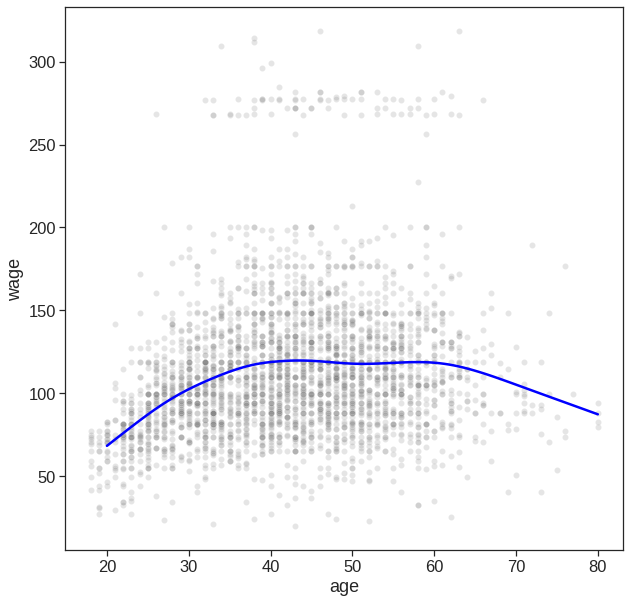

In [ ]:
y_hat = sp.predict(X_test)

#y_hat = model.predict(X)
#predictions = model.get_prediction()
#df_predictions = predictions.summary_frame()


fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X_test.squeeze(), y=y_hat.squeeze(), ax=ax, color='blue')

Refer to [https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Bone%20Mineral%20Density.ipynb](https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Bone%20Mineral%20Density.ipynb) for smoothing spline implementation and [https://scikit-learn.org/stable/modules/preprocessing.html#spline-transformer](https://scikit-learn.org/stable/modules/preprocessing.html#spline-transformer) for B-spline.

### Local regression

In order to perform local regression, we use the `lowess()` function. 

In [ ]:
X = Wage['age']
lowess = sm.nonparametric.lowess
y_hat = lowess(y, X, return_sorted=False)

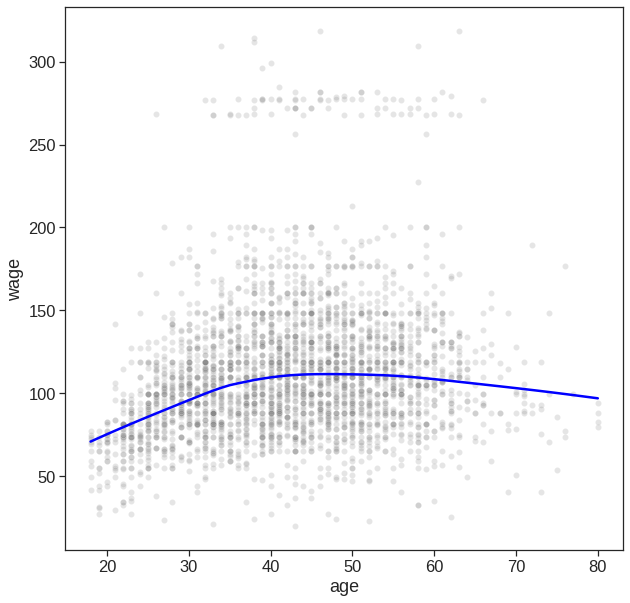

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# Plot estimated f(x)
sns.lineplot(x=X, y=y_hat, ax=ax, color='blue')

## GAMs

We now fit a GAM to predict `wage` using natural spline functions of `year` and `age`,  treating `education` as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the `OLS()` function.

In [ ]:
# we now fit a GAM to predict wage using natural spline functions of year and age, treating education as a qualitative (i.e. categorical) predictor.
age_basis = dmatrix("cr(Wage.age, df=5)", {"Wage.age": Wage.age}, return_type='dataframe')
year_basis = dmatrix("cr(Wage.year, df=4)", {"Wage.year": Wage.year}, return_type='dataframe').drop (['Intercept'], axis = 1)
education_dummies = pd.get_dummies(Wage.education)
education_dummies = education_dummies.drop([education_dummies.columns[0]], axis = 1)

# we concatenate all the predictors
x_all = pd.concat([age_basis, year_basis, education_dummies], axis=1)
# fit the model
model_gam = sm.OLS(Wage['wage'],x_all).fit()
preds = model_gam.predict(x_all)

Text(0, 0.5, 'Preds')

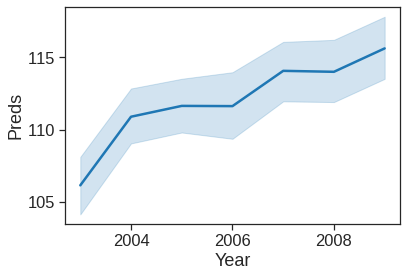

In [ ]:
sns.lineplot(x=Wage['year'], y=preds)
plt.xlabel('Year')
plt.ylabel('Preds')

Text(0, 0.5, 'Preds')

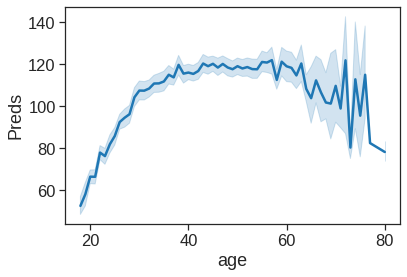

In [ ]:
sns.lineplot(x=Wage['age'],y=preds)
plt.xlabel('age')
plt.ylabel('Preds')
# as it can be seen the figure is not similar as in the text, because here it is not a smooth spline as it was in the 
# book.

Text(0, 0.5, 'Preds')

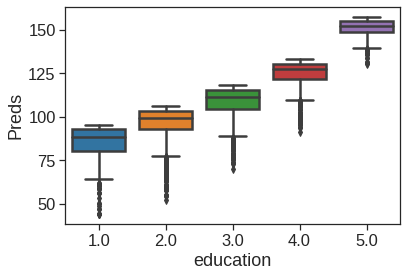

In [ ]:
sns.boxplot(x=Wage['education'],y=preds)
plt.ylabel('Preds')

Now we try to use the GAM module in statsmodel. Here the categorical variables are treated as linear terms and the effect of two explanatory variables is captured by penalized B-splines

Check [https://www.statsmodels.org/stable/generated/statsmodels.gam.generalized_additive_model.GLMGam.html#statsmodels.gam.generalized_additive_model.GLMGam](https://www.statsmodels.org/stable/generated/statsmodels.gam.generalized_additive_model.GLMGam.html#statsmodels.gam.generalized_additive_model.GLMGam) for more details.

In [ ]:
x_spline = Wage[['year', 'age']]
bss = BSplines(x_spline, df=[4, 5], degree=[3, 3])

In [ ]:
gam_bs = GLMGam.from_formula('wage ~ C(education, Treatment(1))', data=Wage,
                          smoother=bss)
res_bs = gam_bs.fit()
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                     2988
Model Family:                Gaussian   Df Model:                        11.00
Link Function:               identity   Scale:                          1238.8
Method:                         PIRLS   Log-Likelihood:                -14934.
Date:                Sun, 06 Nov 2022   Deviance:                   3.7014e+06
Time:                        08:07:42   Pearson chi2:                 3.70e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

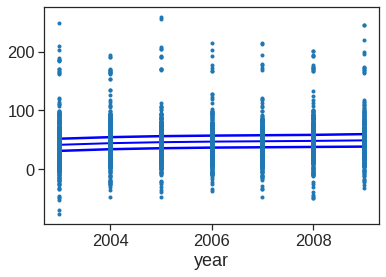

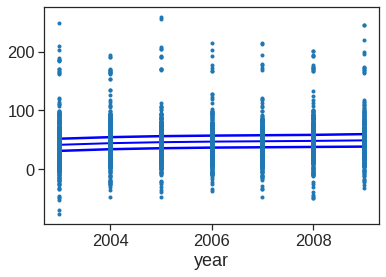

In [ ]:
res_bs.plot_partial(0, cpr=True)

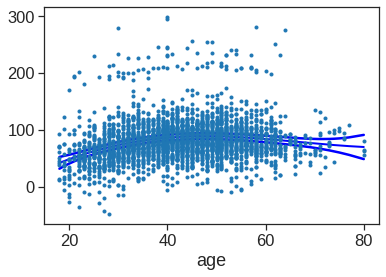

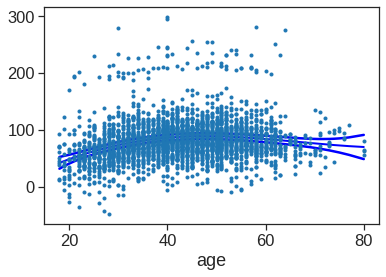

In [ ]:
res_bs.plot_partial(1, cpr=True)

For the plotting, see [https://www.statsmodels.org/dev/generated/statsmodels.gam.generalized_additive_model.GLMGamResults.html](https://www.statsmodels.org/dev/generated/statsmodels.gam.generalized_additive_model.GLMGamResults.html) for more information.

In these plots, the function of `year` looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best:  a GAM that excludes `year` ($\mathcal{M}_1$),  a GAM that uses a linear function of `year` ($\mathcal{M}_2$), or  a GAM that uses a spline function
of `year` ($\mathcal{M}_3$).

In [ ]:
#model1
X_transformed1 = dmatrix('cr(age,df=5) + education', data = {'age':Wage['age'], 'education':Wage['education']}, return_type = 'dataframe')
fit1 = sm.OLS(Wage['wage'],X_transformed1).fit(disp = 0)

#model2
X_transformed2 = dmatrix('year + cr(age,df=5) + education', data = {'year':Wage['year'],'age':Wage['age'], 'education':Wage['education']}, return_type = 'dataframe')
fit2 = sm.OLS(Wage['wage'],X_transformed2).fit(disp = 0)

#model3
X_transformed3 = dmatrix('cr(year,df = 4) + cr(age,df=5) + education', data = {'year':Wage['year'],'age':Wage['age'], 'education':Wage['education']}, return_type = 'dataframe')
fit3 = sm.OLS(Wage['wage'],X_transformed3).fit(disp = 0)


table = sm.stats.anova_lm(fit1,fit2,fit3)
print(table)

   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    2994.0  3.750437e+06      0.0           NaN        NaN       NaN
1    2993.0  3.732809e+06      1.0  17627.473318  14.129318  0.000174
2    2991.0  3.731516e+06      2.0   1293.696286   0.518482  0.595477


The first p value is small enough to conclude that model1 is not enough to explain the data, and model2 is better. The second p value is not significant enough to say that model 3 is better than model2, Hence we conclude that model 2 is the best choice among the three.

In [ ]:
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     199.0
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          5.75e-214
Time:                        08:09:30   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.991e+04
Df Residuals:                    2993   BIC:                         2.995e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1957.3820    532.924  

We can also use local regression fits as building blocks in a GAM.

In [ ]:
X = Wage['age']
y = Wage['wage']
# Create lowess feature for age
Wage['age_lowess'] = sm.nonparametric.lowess(y, X, frac=.7, return_sorted=False)

# Fit logistic regression model
X_transformed = dmatrix('cr(year, df=4)+ age_lowess + education', data = {'year':Wage['year'], 'age_lowess':Wage['age_lowess'], 'education':Wage['education']}, return_type = 'dataframe')

model = sm.OLS(y, X_transformed).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     239.0
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          2.74e-215
Time:                        08:09:31   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.990e+04
Df Residuals:                    2994   BIC:                         2.994e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -38.2295      5.97

Check 
[https://www.statsmodels.org/stable/generated/statsmodels.gam.generalized_additive_model.LogitGam.html#statsmodels.gam.generalized_additive_model.LogitGam](https://www.statsmodels.org/stable/generated/statsmodels.gam.generalized_additive_model.LogitGam.html#statsmodels.gam.generalized_additive_model.LogitGam) for more information

In `Python`, we can also use the  `pyGAM`  package. It provides methods for regression and classification. 

Check [https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Models](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Models) for more details

In [ ]:
from pygam import LinearGAM, s, f

In [ ]:
Wage = pd.read_csv('/content/drive/MyDrive/Lab/Data/Wage.csv')
Wage['education'] = Wage['education'].map({'1. < HS Grad': 0.0, 
                                                 '2. HS Grad': 1.0, 
                                                 '3. Some College': 2.0,
                                                 '4. College Grad': 3.0,
                                                 '5. Advanced Degree': 4.0
                                                })

In [ ]:
X = Wage[['year','age','education']]
y = Wage['wage']

In [ ]:
## model where s means penalized B-spline and f is the factor term
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X.to_numpy(), y.values)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 432x288 with 0 Axes>

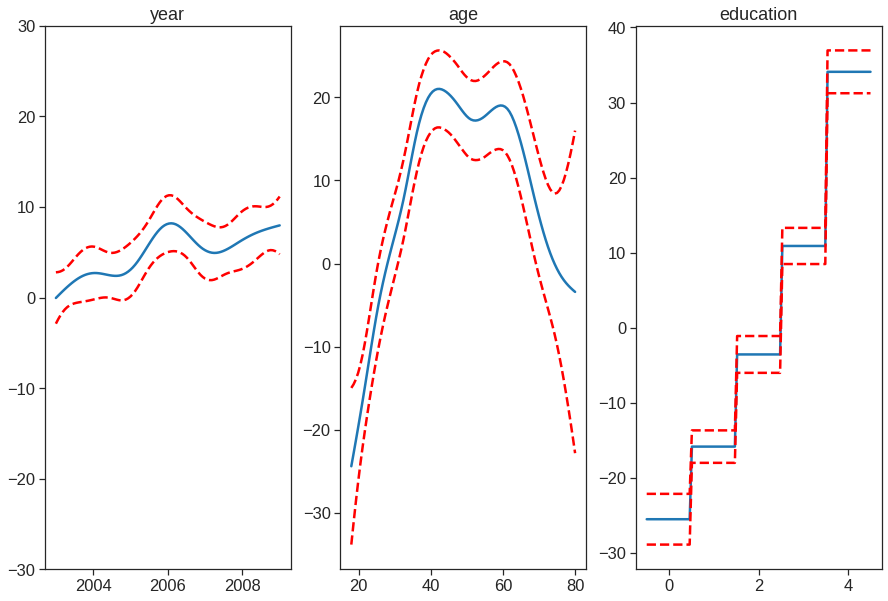

In [ ]:
## plotting
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,10))

titles = ['year', 'age', 'education']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX), ax=ax)
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX,  width=.95)[1][:,0], ls='--', ax=ax, color='red')
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX,  width=.95)[1][:,1], ls='--', ax=ax, color='red')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [ ]:
gam.summary() #Even though our model allows coefficients, our smoothing penalty reduces us to just 19 effective degrees of freedom

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0107
                                                AICc:                                           48274.2999
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


Use `LogisticGAM` for classification 

In [ ]:
from pygam import LogisticGAM, s, f, l

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


<Figure size 432x288 with 0 Axes>

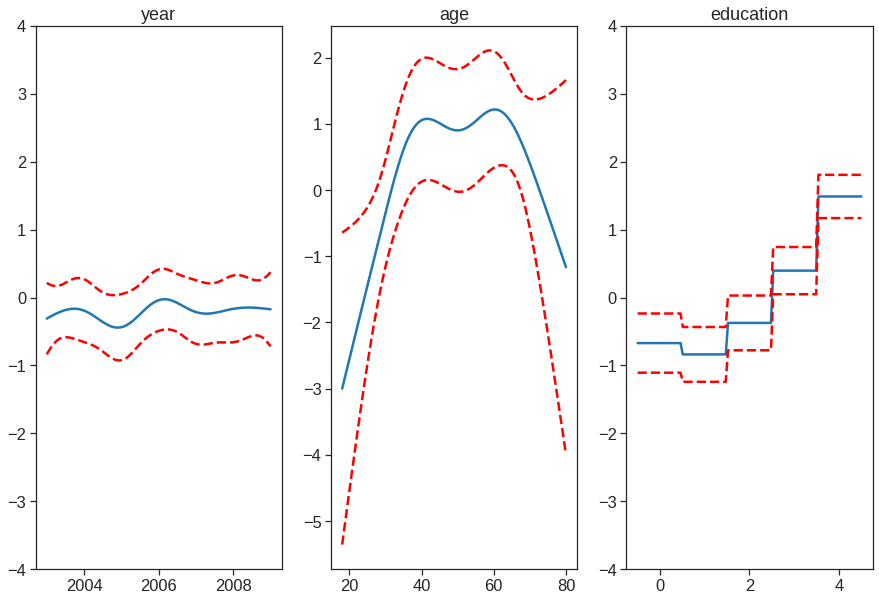

In [ ]:
Wage['wage_binary'] = np.where(Wage['wage']>250,1,0)
y = Wage['wage_binary']

gam = LogisticGAM(s(0) + s(1) + f(2)).gridsearch(X.to_numpy(), y.values)

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,10))

titles = ['year', 'age', 'education']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylim(-4,4)
    elif i==2:
        ax.set_ylim(-4,4)